In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
import time

from scipy.ndimage import gaussian_filter

# Vignetted Image

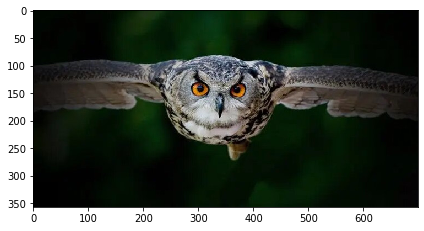

In [2]:
image = io.imread('data/chouette.jpg')
io.imshow(image)

To correct the vignetting of this image we have decided to try to implement the method mentioned in the paper [Revisiting Image Vignetting Correction by Constrained Minimization of Log-Intensity Entropy](https://www.researchgate.net/publication/300786398_Revisiting_Image_Vignetting_Correction_by_Constrained_Minimization_of_Log-Intensity_Entropy) written by  **Laura Lopez Fuentes**.

# Revisiting Image Vignetting Correction by Constrained Minimization of Log-Intensity Entropy

This method uses a sixth grade polynom as gain function of the form $f(r) = 1 + ar^2 + br^4 + cr^6$. This polynom depends on the distance from the image center to the pixel being treated and named $r$ in the previous formula.

## Polynom checking

To avoid computional costs, we will write a function that checks if our polynom respect some discriminating conditions.

In [3]:
def check_polynom(coeffs):
    a, b, c = coeffs
    
    if (a > 0 and b == 0 and c == 0): # C1
        return True
    elif (a >= 0 and b > 0 and c == 0): # C2
        return True
    elif (c == 0 and b < 0 and -a <= 2 * b): # C3
        return True
    elif (c > 0 and b ** 2 < 3 * a * c): # C4
        return True
    elif (c > 0 and b ** 2 == 3 * a * c and b >= 0): # C5
        return True
    elif (c > 0 and b ** 2 == 3 * a * c and -b >= 3 * c): # C6
        return True
    elif (c == 0):
        return False
    
    right_root = (-2 * b + math.sqrt(4 * b ** 2 - 12 * a * c)) / (6 * c)
    
    if (c > 0 and b ** 2 > 3 * a * c and right_root <= 0): # C7
        return True
    
    left_root = (-2 * b - math.sqrt(4 * b ** 2 - 12 * a * c)) / (6 * c)
    
    if (c < 0 and b ** 2 > 3 * a * c and left_root >= 1): # C8
        return True
    
    return c < 0 and b ** 2 > 3 * a * c and right_root >= 1 and left_root <= 0 # C9

## Polynom computing

In [4]:
def compute_polynom(radius, coeffs):
    a, b, c = coeffs
    return 1 + a * np.power(radius, 2) + b * np.power(radius, 4) + c * np.power(radius, 6)

This polynom is used as a filter on the grayscale image. To maximize the efficacity of this gain function, we will use the log-intensity entropy as cost function.

## Log-Intensity Entropy

The log-intensity entropy is representative how messy the intensity is in the image. Thereby, the vignetting should be the main reason of the log-intensity entropy increase and we should try to minimize the log-intensity entropy to improve the quality of the image.

In [5]:
def compute_entropy(image):
    histogram_length = 256
    histogram = np.zeros(histogram_length, dtype = np.float32)
    log_intensity = ((histogram_length - 1) / np.log2(histogram_length)) * np.log2(1 + image)
    
    floor, ceil = np.floor(log_intensity).astype(np.uint8), np.ceil(log_intensity).astype(np.uint8)
    np.add.at(histogram, floor, 1 + floor - log_intensity)
    np.add.at(histogram, ceil, ceil - log_intensity)
    
    histogram = gaussian_filter(histogram, sigma = 2.25)
    
    result = histogram / np.sum(histogram)
    
    result[result > 0] = result[result > 0] * np.log2(result[result > 0])
    return np.sum(result)

We apply a gaussian filter to our histogram because vignetting can be simulated with a gaussian kernel 2D. For the same reasons the conditions we are checking on our polynom are here to check if our polynom has a gaussian look.

## Radius computing

The next step is to compute the distance from the pixel we are treating to the center of the image.

In [6]:
def compute_radius(image, image_center):
    rows, cols = image.shape
    row_center, col_center = image_center
    distance = math.sqrt(row_center ** 2 + col_center ** 2)
    
    radius = np.zeros(rows * cols, dtype = np.float32)
    for row in range(rows):
        for col in range(cols):
            radius[row * cols + col] = math.sqrt((row - row_center) ** 2 + (col - col_center) ** 2) / distance
            
    return radius

To maximize the effiency of the algorithm, we will not consider the middle of the image as the center of the image but we would rather use the image intensity center called *center of mass*. The *center of mass* is calcuted from the following formula:

$$
CM = ({\sum(i.I(i, j)) \over \sum(I(i, j))}, {\sum(j.I(i, j)) \over \sum(I(i, j))})
$$

In [7]:
def compute_center_of_mass(image):
    rows, cols = image.shape
    image_sum = np.sum(image)
    row_indexes = np.arange(1, rows + 1)
    row_sum = np.sum(np.multiply(image.T, row_indexes))
    col_indexes = np.arange(1, cols + 1)
    col_sum = np.sum(np.multiply(image, col_indexes))
    return (row_sum // image_sum, col_sum // image_sum)

## Assembling all

The algorithm will be runed on grayscale image to find our optimal polynom and apply it on every channel.

In [8]:
def correct_vignetting(image):
    grayscale_image = image.mean(axis = 2)
    
    base_shape = grayscale_image.shape
    a, b, c, delta = 0.0, 0.0, 0.0, 8.0
    
    center_of_mass = compute_center_of_mass(grayscale_image)
    radius = compute_radius(grayscale_image, center_of_mass)
    Hmin = compute_entropy(grayscale_image)
    grayscale_image = grayscale_image.flatten()
    
    while (delta > (1 / 256)):
        coeffs = np.array([(a + delta, b, c), (a - delta, b, c),
                            (a, b + delta, c), (a, b - delta, c),
                            (a, b, c + delta), (a, b, c - delta)])
        
        for vector in coeffs:
            if (check_polynom(vector)):
                polynom = compute_polynom(radius, vector)
                result_image = grayscale_image * polynom
                H = compute_entropy(result_image)
                if (Hmin > H):
                    Hmin, delta, (a, b, c) = H, 16.0, vector
        
        delta /= 2
          
    return np.clip(image * np.stack([polynom.reshape(base_shape)] * 3, axis = 2), 0, 255).astype(np.uint8)

In [9]:
start_time = time.time()

test = correct_vignetting(image)

print("--- It took %s seconds ---" % (time.time() - start_time))

--- It took 13.870163440704346 seconds ---


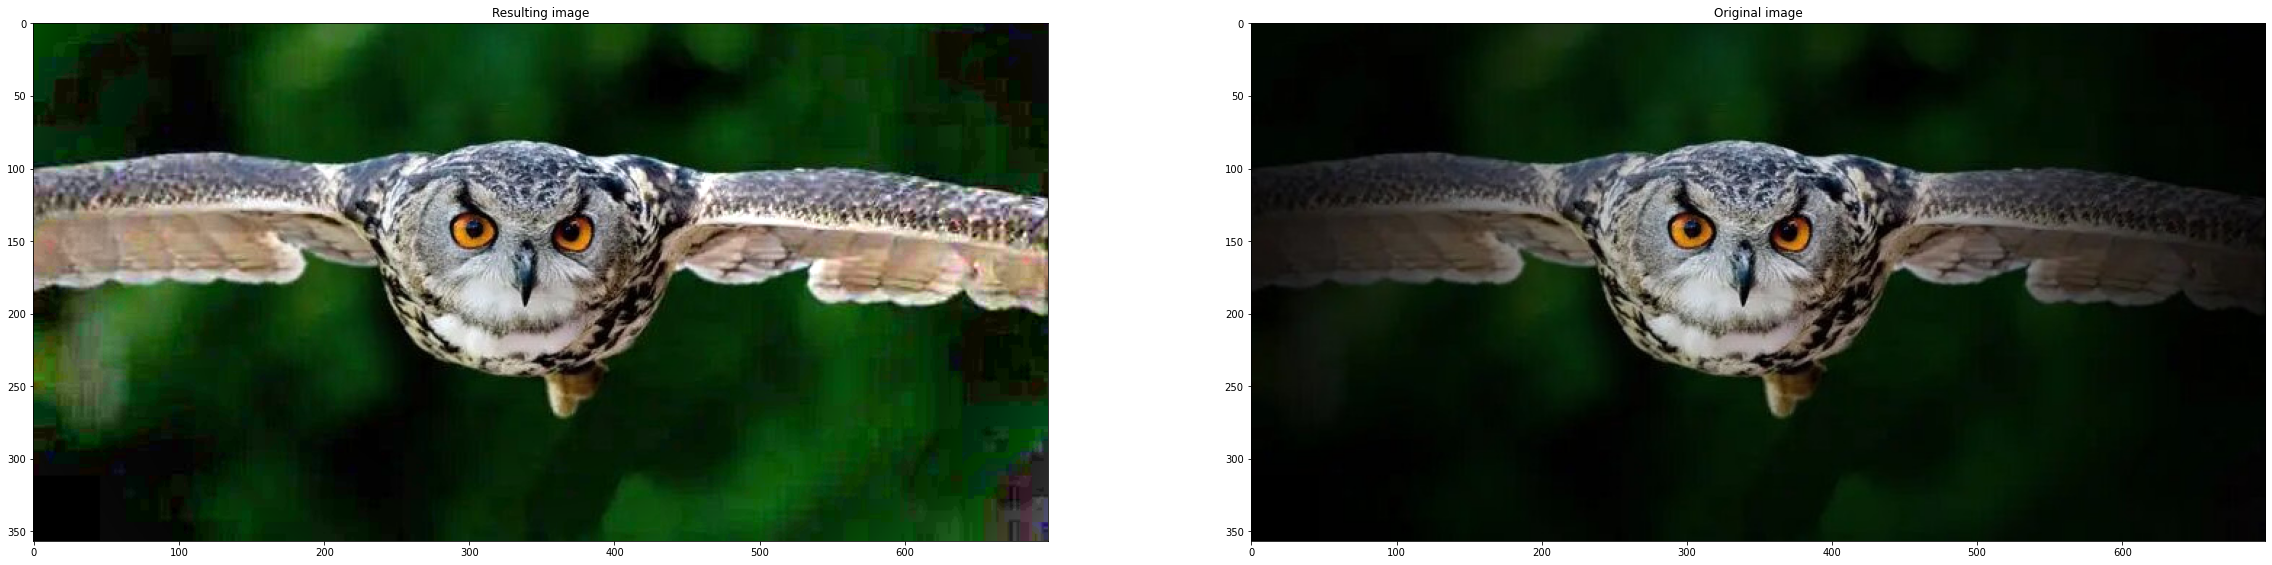

In [10]:
plt.figure(figsize=(40,40))
plt.subplot(121)
plt.imshow(test, cmap = 'gray')
plt.title('Resulting image');
plt.subplot(122)
plt.imshow(image, cmap='gray')
plt.title('Original image');

io.imsave('output/vignetting_corrected.jpg', test)

Our solution gives pretty good result and is relatively fast compared to other implementations of the state of the art even if it is computional cost is to big for being embedded. Even if the code is already vectorized, it should be still improvable.

Some important artifacts appear on pixels that are far from the center of mass if the image contains an important vignetting.